In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

In [25]:
# Loading stock Data
tickers = ["COFORGE.NS", "TATAMOTORS.NS", "RELIANCE.NS"]
benchmark = "^NSEI"  # Nifty 50
data = yf.download(tickers + [benchmark], start="2015-01-01")["Close"]


C:\Users\swana\AppData\Local\Temp\ipykernel_10340\1116044479.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers + [benchmark], start="2015-01-01")["Close"]
[*********************100%***********************]  4 of 4 completed


In [26]:
data.head()

Ticker,COFORGE.NS,RELIANCE.NS,TATAMOTORS.NS,^NSEI
Date,,,,
2015-01-01,62.825363,189.999802,485.740906,NaN
2015-01-02,65.059013,189.496933,498.750519,8395.450195
2015-01-05,64.126190,187.421280,510.444550,8378.400391
2015-01-06,62.448803,178.915237,488.615692,8127.350098
2015-01-07,60.959690,182.809814,481.258179,8102.100098


In [ ]:
## Spotting Null Values
data.isnull().sum()

Ticker
COFORGE.NS       1
RELIANCE.NS      0
TATAMOTORS.NS    0
^NSEI            9
dtype: int64

In [ ]:
## Dropping Null Values
data.dropna(inplace=True)

In [30]:
data.isnull().sum()

Ticker
COFORGE.NS       0
RELIANCE.NS      0
TATAMOTORS.NS    0
^NSEI            0
dtype: int64

In [31]:
returns=data.pct_change()

In [32]:
# Proportions of weight
weights = np.array([0.4, 0.35, 0.25]) 
portfolio_returns = (returns[tickers] @ weights) 


In [33]:
# Annualized Prortfolio stats
def calc_annual_return(returns, periods_per_year=252):
    compounded = (1 + returns).prod()
    n_periods = returns.shape[0]
    return compounded ** (periods_per_year / n_periods) - 1


def calc_annual_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)


def calc_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    excess_ret = returns - risk_free_rate/periods_per_year
    ann_excess_ret = calc_annual_return(excess_ret, periods_per_year)
    ann_vol = calc_annual_volatility(returns, periods_per_year)
    return ann_excess_ret / ann_vol


In [34]:
# calculating Risk,Return,Sharpe
annual_return = calc_annual_return(portfolio_returns)
annual_volatility = calc_annual_volatility(portfolio_returns)
sharpe = calc_sharpe_ratio(portfolio_returns)


In [35]:
annual_return,annual_volatility,sharpe

(np.float64(0.24302734946342075),
 np.float64(0.277467862693471),
 np.float64(0.8758756675611908))

In [37]:
# Finding Alpha and Beta for each stock
X = sm.add_constant(data["^NSEI"])  

alphas = {}
betas = {}

for ticker in tickers:  
    y = data[ticker]  
    model = sm.OLS(y, X).fit() 
    alpha, beta = model.params  
    alphas[ticker] = alpha
    betas[ticker] = beta


In [38]:
# Monte Carlo Simulation for Portfolio with Covariance
mu_vec = returns[tickers].mean().values * 252
cov_matrix = returns[tickers].cov().values * 252
mu_vec
cov_matrix


array([[0.16704695, 0.03919213, 0.02873047],
       [0.03919213, 0.17730136, 0.04056541],
       [0.02873047, 0.04056541, 0.07556237]])

In [39]:
# Giving Values for Monte Carlo Simulation
np.random.seed(42)
n_sims = 10 
N = 252 
dt = 1 / 252 
simulations = np.zeros((N, n_sims))  
S0_vec = data[tickers].iloc[-1].values



In [40]:
## Difining monte carlo simulation
for j in range(n_sims):
    prices = np.zeros((N, len(tickers)))
    prices[0] = S0_vec
    for t in range(1, N):
        Z = np.random.multivariate_normal(np.zeros(len(tickers)), cov_matrix * dt)
        drift = mu_vec * dt
        diffusion = Z
        prices[t] = prices[t-1] * np.exp(drift + diffusion)
    # portfolio value
    simulations[:, j] = prices @ weights


In [41]:
# Black–Scholes Model for one stock (AAPL)
def black_scholes(S, K, T, r, sigma, option="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == "call":
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:  # put option
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

black_scholes

<function __main__.black_scholes(S, K, T, r, sigma, option='call')>

In [42]:
S0 = data["COFORGE.NS"].iloc[-1]
option_price = black_scholes(S=S0, K=200, T=1, r=0.05, sigma=annual_volatility)
option_price

np.float64(1534.054163927982)

In [43]:
print(simulations)

[[1263.17000732 1263.17000732 1263.17000732 ... 1263.17000732
  1263.17000732 1263.17000732]
 [1254.65046938 1241.46449429 1258.40006911 ... 1203.67408489
  1274.90885222 1264.4981421 ]
 [1222.36482988 1232.14631937 1219.51864406 ... 1216.03502851
  1290.723261   1241.1727231 ]
 ...
 [1138.00538492 1105.03769044 1606.9365699  ... 1935.32372612
  2134.60073009 1926.88565692]
 [1145.78880311 1084.66021454 1590.72794758 ... 1952.48055976
  2098.82842729 1926.25631387]
 [1157.17743829 1082.69400333 1558.69006173 ... 1967.59352372
  2155.82280471 1914.36081255]]


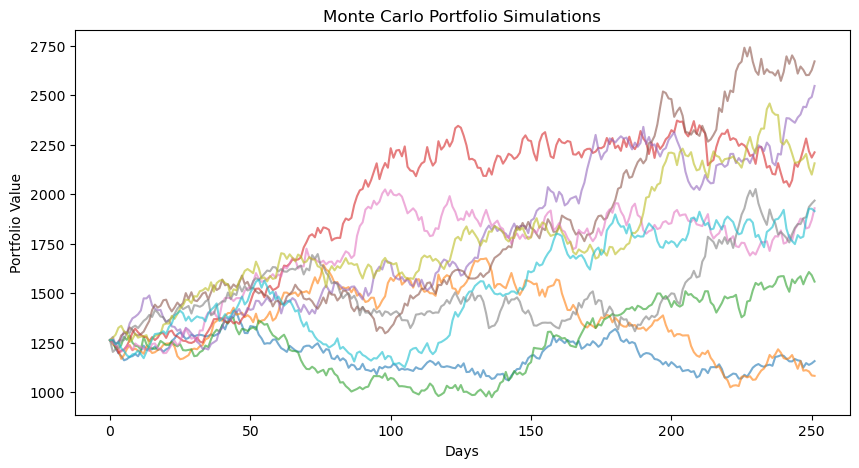

In [44]:
# Ploting Monte Carlo Portfolio Paths
plt.figure(figsize=(10,5))
plt.plot(simulations, alpha=0.6)
plt.title("Monte Carlo Portfolio Simulations")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.show()
